In [17]:
#all necessary imports
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
import glob,re, os, sys, random
from sklearn.model_selection import cross_val_predict,cross_validate
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from nltk.corpus import stopwords
from random import shuffle
random_seed = [6789, 232345, 334456, 454567, 567448, 67839, 9822276, 763454, 644543, 3454421]

In [18]:
def extract_text(starts, ends, cases, violation):
    facts = []
    D = []
    years = []
    for case in cases:
        contline = ''
        year = 0
        with open(case, 'r') as f:
            for line in f:
                dat = re.search('^([0-9]{1,2}\s\w+\s([0-9]{4}))', line)
                if dat != None:
                    year = int(dat.group(2))
                    break
            if year>0:
                years.append(year)
                wr = 0
                for line in f:
                    if wr == 0:
                        if re.search(starts, line) != None:
                            wr = 1
                    if wr == 1 and re.search(ends, line) == None:
                        contline += line
                        contline += '\n'
                    elif re.search(ends, line) != None:
                        break
                facts.append(contline)
    for i in range(len(facts)):
        D.append((facts[i], violation, years[i])) 
    return D

In [19]:
def extract_parts(train_path, violation, part): #extract text from different parts
    cases = glob.glob(train_path)

    facts = []
    D = []
    years = []
    
    if part == 'relevant_law': #seprarte extraction for relevant law
        for case in cases:
            year = 0
            contline = ''
            with open(case, 'r') as f:
                for line in f:
                    dat = re.search('^([0-9]{1,2}\s\w+\s([0-9]{4}))', line)
                    if dat != None:
                        year = int(dat.group(2))
                        break
                if year> 0:
                    years.append(year)
                    wr = 0
                    for line in f:
                        if wr == 0:
                            if re.search('RELEVANT', line) != None:
                                wr = 1
                        if wr == 1 and re.search('THE LAW', line) == None and re.search('PROCEEDINGS', line) == None:
                            contline += line
                            contline += '\n'
                        elif re.search('THE LAW', line) != None or re.search('PROCEEDINGS', line) != None:
                            break
                    facts.append(contline)
        for i in range(len(facts)):
            D.append((facts[i], violation, years[i]))
        
    if part == 'facts':
        starts = 'THE FACTS'
        ends ='THE LAW'
        D = extract_text(starts, ends, cases, violation)
    if part == 'circumstances':
        starts = 'CIRCUMSTANCES'
        ends ='RELEVANT'
        D = extract_text(starts, ends, cases, violation)
    if part == 'procedure':
        starts = 'PROCEDURE'
        ends ='THE FACTS'
        D = extract_text(starts, ends, cases, violation)
    if part == 'procedure+facts':
        starts = 'PROCEDURE'
        ends ='THE LAW'
        D = extract_text(starts, ends, cases, violation)
    return D

In [20]:
def train_model_cross_val(Xtrain, Ytrain, vec, c, cv):
    pipeline = Pipeline([('features', FeatureUnion([vec], )),
                         ('classifier', LinearSVC(C=c))])
    acc = cross_validate(
        pipeline, Xtrain, Ytrain, cv=cv)  #10-fold cross-validation
    return acc['test_score']

In [21]:
def run_pipeline(part, vec, c,article, n_shuffles=10, cv=10):  #run tests

    v = extract_parts(path + 'train/' + article + '/violation/*.txt',
                      'violation', part)
    nv = extract_parts(path + 'train/' + article + '/non-violation/*.txt',
                       'non-violation', part)
    v_t = extract_parts(path + 'test20/' + article + '/violation/*.txt',
                      'violation', part)
    nv_t = extract_parts(path + 'test20/' + article + '/non-violation/*.txt',
                       'non-violation', part)
    original_dataset = v + nv + v_t + nv_t
    accuracy= np.zeros((n_shuffles, cv), dtype=float)
    for i in range(n_shuffles):
        print('*** '+str(cv)+'-fold cross-validation - shuffle '+str(i)+' ***')
        dataset = original_dataset.copy()
        random.seed(random_seed[i])
        shuffle(dataset)
        Xtrain = [i[0] for i in dataset]
        Ytrain = [i[1] for i in dataset]
        test_score=train_model_cross_val(Xtrain, Ytrain, vec, c, cv)
        for j in range(cv) :
            accuracy[i][j]=test_score[j]
    return accuracy

In [23]:
if __name__ == "__main__":
    ##INDICATE THE PATH TO THE DATA
    path = 'crystal_ball_data/'
    #articles = ['Article02', 'Article03', 'Article05', 'Article06', 'Article08', 'Article10', 'Article11', 'Article13', 'Article14']
    articles = [
        'Article02', 'Article03', 'Article05', 'Article06', 'Article08',
        'Article10', 'Article11', 'Article13', 'Article14'
    ]
    total_accuracy = []
    for article in articles:  #the parameters were determined using grid-search
        print(article)
        if article == 'Article02':
            vec = ('wordvec',
                   TfidfVectorizer(
                       analyzer='word',
                       ngram_range=(3, 4),
                       binary=False,
                       lowercase=True,
                       min_df=2,
                       norm='l2',
                       stop_words='english',
                       use_idf=True))
            c = 0.1
            total_accuracy.append(
                [article,
                 run_pipeline('procedure+facts', vec, c, article)])
        if article == 'Article03':
            vec = ('wordvec',
                   TfidfVectorizer(
                       analyzer='word',
                       binary=True,
                       lowercase=True,
                       min_df=2,
                       ngram_range=(1, 1),
                       norm='l2',
                       stop_words='english',
                       use_idf=True))
            c = 0.1
            total_accuracy.append(
                [article,
                 run_pipeline('procedure+facts', vec, c, article)])
        if article == 'Article05':
            vec = ('wordvec',
                   TfidfVectorizer(
                       analyzer='word',
                       binary=False,
                       lowercase=True,
                       min_df=3,
                       ngram_range=(1, 1),
                       norm='l2',
                       stop_words='english',
                       use_idf=True))
            c = 1
            total_accuracy.append(
                [article,
                 run_pipeline('procedure+facts', vec, c, article)])
        if article == 'Article06':
            vec = ('wordvec',
                   TfidfVectorizer(
                       analyzer='word',
                       binary=False,
                       lowercase=True,
                       min_df=2,
                       ngram_range=(2, 4),
                       norm='l2',
                       stop_words='english',
                       use_idf=True))
            c = 5
            total_accuracy.append(
                [article, run_pipeline('procedure+facts', vec, c)])
        if article == 'Article08':
            vec = ('wordvec',
                   TfidfVectorizer(
                       analyzer='word',
                       binary=True,
                       lowercase=True,
                       min_df=1,
                       ngram_range=(3, 3),
                       norm='l2',
                       stop_words='english',
                       use_idf=False))
            c = 1
            total_accuracy.append(
                [article,
                 run_pipeline('procedure+facts', vec, c, article)])
        if article == 'Article10':
            vec = ('wordvec',
                   TfidfVectorizer(
                       analyzer='word',
                       binary=False,
                       lowercase=True,
                       min_df=1,
                       ngram_range=(1, 1),
                       norm='l2',
                       stop_words='english',
                       use_idf=False))
            c = 5
            total_accuracy.append(
                [article, run_pipeline('procedure+facts', vec, c)])
        if article == 'Article11':
            vec = ('wordvec',
                   TfidfVectorizer(
                       analyzer='word',
                       binary=False,
                       lowercase=True,
                       min_df=2,
                       ngram_range=(1, 1),
                       norm='l1',
                       stop_words='english',
                       use_idf=False))
            c = 1
            total_accuracy.append(
                [article, run_pipeline('procedure+facts', vec, c)])
        if article == 'Article13':
            vec = ('wordvec',
                   TfidfVectorizer(
                       analyzer='word',
                       binary=False,
                       lowercase=True,
                       min_df=1,
                       ngram_range=(1, 2),
                       norm='l2',
                       stop_words='english',
                       use_idf=True))
            c = 5
            total_accuracy.append(
                [article, run_pipeline('procedure+facts', vec, c)])
        if article == 'Article14':
            vec = ('wordvec',
                   TfidfVectorizer(
                       analyzer='word',
                       binary=True,
                       lowercase=True,
                       min_df=3,
                       ngram_range=(1, 1),
                       norm='l2',
                       stop_words='english',
                       use_idf=True))
            c = 5
            total_accuracy.append(
                [article, run_pipeline('procedure+facts', vec, c)])

    for element in total_accuracy:
        print(element[0])
        print("Mean: ", element[1].mean(), "\n")

Article05
*** 10-fold cross-validation - shuffle 0 ***
*** 10-fold cross-validation - shuffle 1 ***
*** 10-fold cross-validation - shuffle 2 ***
*** 10-fold cross-validation - shuffle 3 ***
*** 10-fold cross-validation - shuffle 4 ***
*** 10-fold cross-validation - shuffle 5 ***
*** 10-fold cross-validation - shuffle 6 ***
*** 10-fold cross-validation - shuffle 7 ***
*** 10-fold cross-validation - shuffle 8 ***
*** 10-fold cross-validation - shuffle 9 ***
Article05
Mean:  0.7527192982456142 



In [24]:
for res in total_accuracy :
    np.savetxt("medvedeva/"+res[0],res[1])

mean:  0.8005476190476188
min:  0.6944444444444444
max:  0.9142857142857143


array([0.80123016, 0.80166667, 0.8027381 , 0.79710317, 0.80293651,
       0.80571429, 0.8025    , 0.79579365, 0.80277778, 0.79301587])

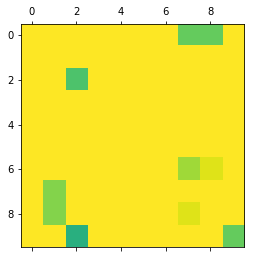

In [70]:
import matplotlib.pyplot as plt

plt.matshow(total_accuracy[0][1], vmin=0.6, vmax=0.75)

print("mean: ", total_accuracy[0][1].mean())
print("min: ", total_accuracy[0][1].min())
print("max: ", total_accuracy[0][1].max())
total_accuracy[0][1].mean(1)